# Inference Notebook
- This notebook serves to import trained models and generate new samples.
- You should only need to edits the [Checkpoint & Configs](#Checkpoint-\&-Configs) and [Define Sample Parameters](#Define-Sample-Parameters) cells.
- Currently this notebook only offers unconditional generation, but I plan to include more features in the future.
- Have fun creating new sounds!

*(NOTE: Don't do "run all" in Jupyter. For some reason it doesn't output anything when I used this option. It may work in other environments, but just a heads up!)*

#### Imports
Import necessary libraries to run the notebook

In [1]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchaudio
from torch import nn
import pytorch_lightning as pl
from ema_pytorch import EMA
import IPython.display as ipd
import yaml
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

/home/crlandsc/anaconda3/envs/tiny-audio-diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Checkpoint & Configs
- Replace these paths with the path to your model's checkpoint and configs.
- Pre-trained models are availlable to download on Hugging Face.

|Model|Link|
|---|---|
|Kicks|[crlandsc/tiny-audio-diffusion-kicks](https://huggingface.co/crlandsc/tiny-audio-diffusion-kicks)|
|Snares|[crlandsc/tiny-audio-diffusion-snares](https://huggingface.co/crlandsc/tiny-audio-diffusion-snares)|
|Hi-hats|[crlandsc/tiny-audio-diffusion-hihats](https://huggingface.co/crlandsc/tiny-audio-diffusion-hihats)|

In [2]:
# Load model checkpoint
ckpt_path = "./saved_models/kicks/kicks_v7.ckpt" # path to model checkpoint
config_path = "./saved_models/kicks/config.yaml" # path to model config

### Functions & Models
- Functions and models definitions

In [3]:
# Load configs
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
pl_configs = config['model']
model_configs = config['model']['model']

In [4]:
def plot_mel_spectrogram(sample):
    transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        hop_length=512,
        n_mels=80,
        center=True,
        norm="slaney",
    )

    spectrogram = transform(torch.mean(sample, dim=0)) # downmix and cal spectrogram
    spectrogram = torchaudio.functional.amplitude_to_DB(spectrogram, 1.0, 1e-10, 80.0)

    # Plot the Mel spectrogram
    fig = plt.figure(figsize=(7, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Frame')
    plt.ylabel('Mel Bin')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    
    return fig

In [5]:
# Define PyTorch Lightning model
class Model(pl.LightningModule):
    def __init__(
        self,
        lr: float,
        lr_beta1: float,
        lr_beta2: float,
        lr_eps: float,
        lr_weight_decay: float,
        ema_beta: float,
        ema_power: float,
        model: nn.Module,
    ):
        super().__init__()
        self.lr = lr
        self.lr_beta1 = lr_beta1
        self.lr_beta2 = lr_beta2
        self.lr_eps = lr_eps
        self.lr_weight_decay = lr_weight_decay
        self.model = model
        self.model_ema = EMA(self.model, beta=ema_beta, power=ema_power)

### Instantiate model
*NOTE: This model setup needs to exactly match the model that was trained*

- This cell instantiates the model (no weights) using the config.yaml file. This is structure is critical to make sure that the model weights can be loaded in correctly.

In [6]:
# Instantiate model (must match model that was trained)

# Diffusion model
model = DiffusionModel(
    net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
    in_channels=model_configs['in_channels'], # U-Net: number of input/output (audio) channels
    channels=model_configs['channels'], # U-Net: channels at each layer
    factors=model_configs['factors'], # U-Net: downsampling and upsampling factors at each layer
    items=model_configs['items'], # U-Net: number of repeating items at each layer
    attentions=model_configs['attentions'], # U-Net: attention enabled/disabled at each layer
    attention_heads=model_configs['attention_heads'], # U-Net: number of attention heads per attention item
    attention_features=model_configs['attention_features'], # U-Net: number of attention features per attention item
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler # The diffusion sampler used
)

# pl model
model = Model(
    lr=pl_configs['lr'],
    lr_beta1=pl_configs['lr_beta1'],
    lr_beta2=pl_configs['lr_beta2'],
    lr_eps=pl_configs['lr_eps'],
    lr_weight_decay=pl_configs['lr_weight_decay'],
    ema_beta=pl_configs['ema_beta'],
    ema_power=pl_configs['ema_power'],
    model=model
)

### Check if GPU available
- This checks to see if a CUDe capable GPU is available to utilize. If so, the model is assigned to the GPU. If not, the model simply remains on the CPU.

In [7]:
# Assign to GPU
if torch.cuda.is_available():
    model = model.to('cuda')
    print(f"Device: {model.device}")

Device: cuda:0


### Load model
- This cell loads the checkpoint weights into the model. It should return `"<All keys matched successfully>"` if successfully loaded.

In [8]:
# Load model checkpoint
checkpoint = torch.load(ckpt_path, map_location='cpu')['state_dict']
model.load_state_dict(checkpoint) # should output "<All keys matched successfully>"

<All keys matched successfully>

## Generate Samples

#### Define Sample Parameters
- sample_length: how long to make the output (measured in samples). Recommended $2^{15}=32768$ (~0.75 sec), as that is what the model was trained on.
- sr (sample rate): sampling rate to output. Recommended industry standard 44.1kHz (44100Hz)
- num_samples: number of new samples that will be generated
- num_steps: number of diffusion steps - tradeoff inference speed for sample quality (10-100 is a good range)
    - 10+ steps - quick generation, alright samples but noticeable high-freq hiss
    - 50+ steps - moderate generation speed, good tradeoff for speed and qualiy (less high-freq hiss)
    - 100+ steps - slow generation speed, high quality samples

Have fun playing around with these parameters! Note that sometimes the model outputs some wild things. This is likely due to the small size of the model as well as the limited training data. Larger models and/or larger and more diverse datasets would improve this.

In [9]:
# Define diffusion paramters
sample_length = 2**15 # 32768 samples @ 44100 = .75 sec
sr = 44100
num_samples = 3 # number of samples to generate
num_steps = 50 # number of diffusion steps, tradeoff inference speed for sample quality (10-100 is a good range)

#### Generate samples
Run the following cell to generate samples based on previously defined parameters

Generated Sample 1


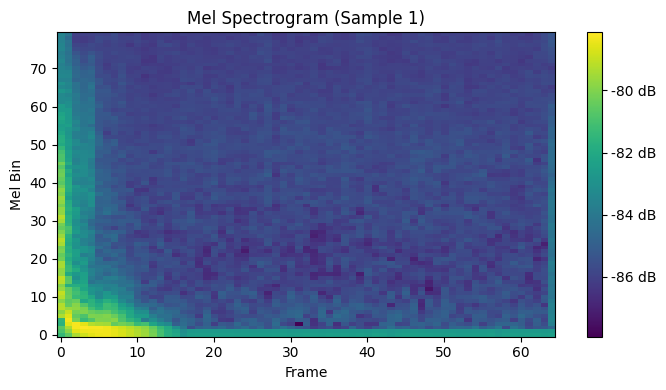

Generated Sample 2


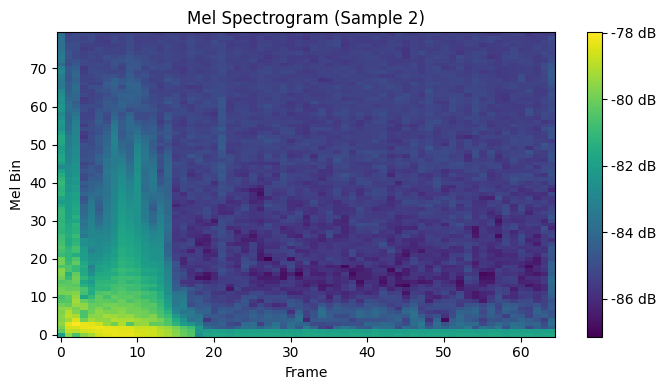

Generated Sample 3


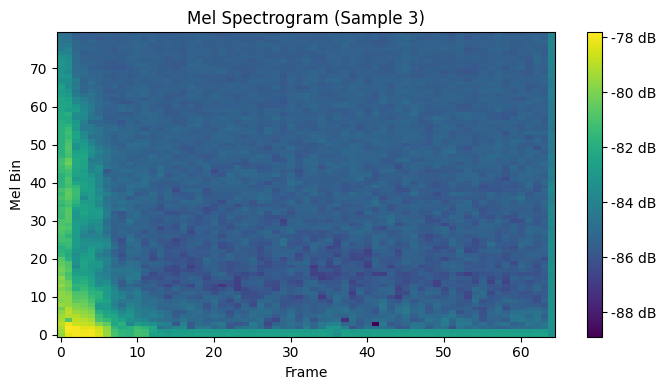

In [10]:
with torch.no_grad():
    all_samples = torch.zeros(2, 0)
    for i in range(num_samples):
        noise = torch.randn((1, 2, sample_length), device=model.device) # [batch_size, in_channels, length]
        generated_sample = model.model_ema.ema_model.sample(noise, num_steps=num_steps).squeeze(0).cpu() # Suggested num_steps 10-100

        print(f"Generated Sample {i+1}")
        display(ipd.Audio(generated_sample, rate=sr))
        
        # concatenate all samples:
        all_samples = torch.concat((all_samples, generated_sample), dim=1)
        
        fig = plot_mel_spectrogram(generated_sample)
        plt.title(f"Mel Spectrogram (Sample {i+1})")
        plt.show()
        
        torch.cuda.empty_cache()

#### Combine all samples
- Option to combine all samples into a single sample

All Samples


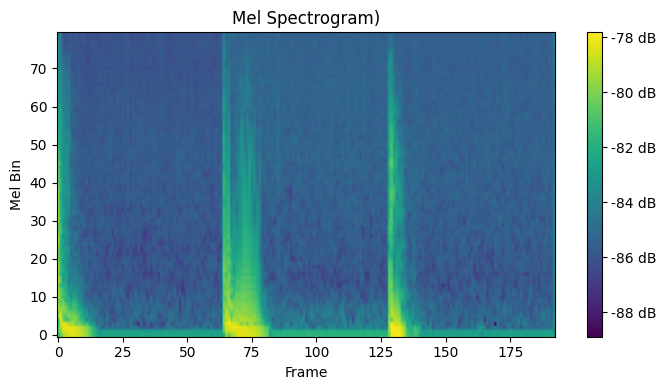

In [11]:
# Optional concatenate all samples
print(f"All Samples")
display(ipd.Audio(all_samples, rate=sr))
fig = plot_mel_spectrogram(all_samples)
plt.title(f"Mel Spectrogram)")
plt.show()

In [ ]:
# TODO: Implement conditional diffusion